In [1]:
import pandas as pd
import numpy as np
import pickle
import json


import matplotlib.pyplot as plt
import plotting as pltt

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull

# files

folder = ''

sims_file = folder+'sims_05.csv'
res_info_folder = folder+'ResInfo/res_info_'
sims_df = pd.read_csv(sims_file)
pickle_files = folder+'specs/'+sims_df['filename']+'.pkl'


filenames = [sims_df['filename'][i] for i in range(len(sims_df))]
res_info_files = [res_info_folder + str(soil_resolution) + '.json' for soil_resolution in sims_df['soil_resolution']]
res_infos = [json.load(open(res_info_file, 'r')) for res_info_file in res_info_files]
sidess = [res_info['sides'] for res_info in res_infos]

elem_map_folder = 'ElemMaps/ELEMS_'
elem_map_files = elem_map_folder +sims_df['soil_resolution'] + '_'+ sims_df['function'] + '_00'+sims_df['id'].apply(str)+'.csv'
elem_maps = [pd.read_csv(elem_map_file) for elem_map_file in elem_map_files]
carbon_levels = [elem_map.iloc[7].values[1:] for elem_map in elem_maps]

filenames = []
midpointss = []
soil_resolutions = []
n_90 = []
n_95 = []
n_99 = []
n_100 = []
n_total = []
detector_spectrums = []


clouds = {
    '90': [],
    '95': [],
    '99': [],
    '100': []
}

cell_portions = []
cell_heatings = []


for i in range(len(sims_df)):

    pickle_file = pickle_files[i]
    soil_resolution = sims_df['soil_resolution'][i]
    soil_resolutions.append(soil_resolution)
    res_info_file = res_info_folder + str(soil_resolution) + '.json'
    res_info = json.load(open(res_info_file, 'r'))
    midpoints = np.array(res_info['midpoints'])
    midpointss.append(midpoints)
    detector_tally_ids = [int(r) for r in res_info['detector_tally_ids']]
    cell_ids = [int(r) for r in res_info['cell_ids']]
    filename = sims_df['filename'][i]
    i_bins, i_spectrums= pickle.load(open(pickle_file, 'rb'))
    detector_energy_bins = i_bins[0][-2]
    detector_spec = i_spectrums[1]
    detector_spectrums.append(detector_spec)
    
    causal_bins = [str(bin)[:len(str(cell_ids[0]))] for bin in i_bins[4][2]]
    causal_bins = (np.array(causal_bins)).astype(int).tolist()
    causal_energy_bins = i_bins[4][-2]
    causal_spec = i_spectrums[4]
    new_shape = np.array(causal_spec.shape)
    new_shape[2] = len(cell_ids)
    new_array = np.zeros(new_shape)
    for j in range(len(cell_ids)):
        if cell_ids[j] in causal_bins:
            new_array[:, :, j] = causal_spec[:, :, causal_bins.index(cell_ids[j])]
    full_causal_spec = new_array
    cell_heating = full_causal_spec[0, 0, :, 0, 0, 0, :, 0]
    cell_heatings.append(cell_heating)
    total_soil_heating = np.sum(cell_heating, axis=0)
    cells_over_total_heating = np.nan_to_num(np.divide(cell_heating, total_soil_heating), copy=False, nan=0.0, posinf=None, neginf=None)
    cells_over_total_heating = cells_over_total_heating/np.sum(cells_over_total_heating)
    cell_portion = np.sum(cells_over_total_heating, axis=1)

    sorted_indicies = np.argsort(cell_portion)[::-1]
    sorted_vals = (cell_portion)[sorted_indicies]
    def percent_cloud(sorted_indicies, sorted_vals, threshold=0.90):
        total = np.sum(sorted_vals)
        cumulative_sum = np.cumsum(sorted_vals)
        percent = cumulative_sum / total
        return sorted_indicies[percent < threshold]
    cell_portion = np.sum(cells_over_total_heating, axis=1)

    cell_portions.append(cell_portion)

    filenames.append(filename)
    
    cloud_90 = percent_cloud(sorted_indicies, sorted_vals, threshold=.90)
    clouds['90'].append(cloud_90)
    n_90.append(len(cloud_90))

    cloud_95 = percent_cloud(sorted_indicies, sorted_vals, threshold=.95)
    clouds['95'].append(cloud_95)
    n_95.append(len(cloud_95))

    cloud_99 = percent_cloud(sorted_indicies, sorted_vals, threshold=.99)
    clouds['99'].append(cloud_99)
    n_99.append(len(cloud_99))

    cloud_100 = percent_cloud(sorted_indicies, sorted_vals, threshold=1.0)
    clouds['100'].append(cloud_100)
    n_100.append(len(cloud_100))

    n_total.append(len(sorted_indicies))

    
# cell_heatings = np.array(cell_heatings)

results_df = pd.DataFrame({
    'filename': filenames,
    'n_90': n_90,
    'n_95': n_95,
    'n_99': n_99,
    'n_100': n_100,
    'n_total': n_total
})

clouds_df = pd.DataFrame({
    'filename': filenames,
    'cloud_90': clouds['90'],
    'cloud_95': clouds['95'],
    'cloud_99': clouds['99'],
})

/tmp/ipykernel_921380/1783280414.py:87: RuntimeWarning: invalid value encountered in divide
  cells_over_total_heating = np.nan_to_num(np.divide(cell_heating, total_soil_heating), copy=False, nan=0.0, posinf=None, neginf=None)


In [2]:
# cell_portions = [cell_portions
# [i].tolist()]


                 
cell_portions_df = pd.DataFrame({
    'filename': filenames,
    'cell_portions': [cell_portions[i].tolist() for i in range(len(cell_portions))]
})

In [3]:
cell_heatings_df = pd.DataFrame({
    'filename': filenames,
    'cell_heatings': cell_heatings
})

In [4]:
_max = np.max([np.max(carbon_level) for carbon_level in carbon_levels])
_min = np.min([np.min(carbon_level) for carbon_level in carbon_levels])

/tmp/ipykernel_921380/715882888.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


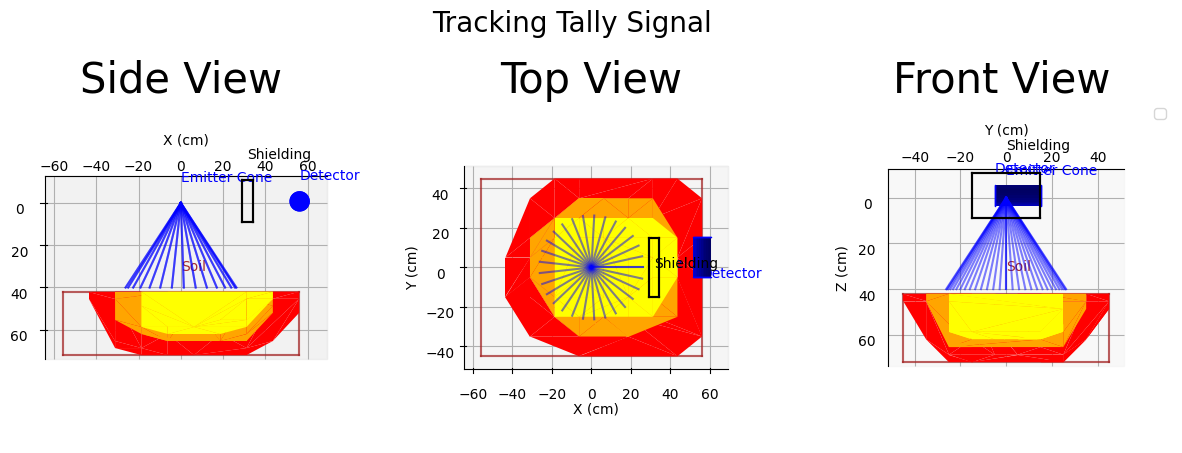

In [5]:
# c = 1

# midpoints = midpointss[c]
# soil_resolution = soil_resolutions[c]


# depth = midpoints[:, 2]
# x = midpoints[:, 0]
# y = midpoints[:, 1]
# depth_prob = cell_heatings_df.iloc[c].cell_heatings.sum(axis=1)

# # histogram with depth as bins
# hist = plt.hist(-depth, bins=np.sort(-np.array(sidess[0][2])), weights=depth_prob, alpha=0.5)
# # plt.plot(hist[1][:-1], hist[0], label='Depth Probability Distribution', color='blue')
# plt.xlabel('Depth (cm)')
# plt.ylabel('Probability')
# plt.title('Depth Signal Distribution')
# plt.grid()
# plt.show()



def cloud_from_cloud(
        ax0, cloud, filter_mask, midpoints,
        alpha=1, 
        color='green',
        zorder=1002,
        c=1,
        ):
    
    # print(f'cloud_from_cloud: {cloud.shape}\n filter {midpoints.shape}\n cell_portions {cell_portions[c].shape}')
    cell_mask_vox = pltt.vox_maker(
        cloud, 
        midpoints, 
        cell_portions[c]
        )
    
    cell_mask_vox = cell_mask_vox & filter_mask
    
    pltt.concave_hull(
        ax0, 
        cell_mask_vox, 
        sidess[c], 
        color=color, 
        alpha=alpha,
        zorder=zorder
        )
    

def cloud3(ax, filter_mask, midpoints, c=1, colors=None):
    # pass
    # The filled argument must be 3D, so we need to reshape total_soil_heating to match the shape of sidess[c]
    # Let's assume sidess[c] is a tuple of 3 arrays representing the grid, and their shapes match the 3D grid shape
    # We'll try to reshape total_soil_heating to the shape of sidess[c][0]
    _shape = [len(sidess[c][0])-1, len(sidess[c][1])-1, len(sidess[c][2])-1]
    x_sides = sidess[c][0]
    y_sides = sidess[c][1]
    z_sides = sidess[c][2]
    z_sides = np.array(z_sides)
    z_sides = -z_sides+42
    filled = np.ones(_shape, dtype=bool)
    # print(f'filled: {filled.shape}')
    # print(f'sides: {z_sides}')
    x, y, z = np.meshgrid(
        x_sides, y_sides, z_sides, indexing='ij'
    )

    # ax.voxels(
    #     x, y, z, filled,
    #     facecolors=colors,
    #     edgecolor='k', linewidth=2,
    # )
    cloud_from_cloud(
        ax, 
        clouds['99'][c], 
        filter_mask, 
        midpoints,
        alpha=1, 
        color='red',
        zorder=1002,
        c=c,
        )


    cloud_from_cloud(
        ax, 
        clouds['95'][c], 
        filter_mask, 
        midpoints,
        alpha=1, 
        color='orange',
        zorder=1002,
        c=c,
        )


    cloud_from_cloud(
        ax, 
        clouds['90'][c], 
        filter_mask, 
        midpoints,
        alpha=1, 
        color='yellow',
        zorder=1002,
        c=c,
        )

soil_on_ax = lambda ax: pltt.plot_box(ax, -56, 56, -45, 45, 42, 42+30, color='brown', alpha=.5, label='Soil', zorder=1)


fig, axs = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(5*3, 5*3))

# side

def tripleview(axs, c=1):
    # c = 1

    midpoints = midpointss[c]
    soil_resolution = soil_resolutions[c]
    soil_res = [int(s) for s in soil_resolution.split('x')]
    # print(midpoints.shape, soil_res)

    depth = midpoints[:, 2]
    x = midpoints[:, 0]
    y = midpoints[:, 1]
    depth_prob = cell_heatings_df.iloc[c].cell_heatings.sum(axis=1)

    _shape = [len(sidess[c][0])-1, len(sidess[c][1])-1, len(sidess[c][2])-1]

    carbon_level = carbon_levels[c]
    _min = np.min(carbon_level)
    _max = np.max(carbon_level)
    carbon_level = (carbon_level-_min)
    carbon_level = carbon_level/(_max-_min)
    carbon_level = plt.colormaps['viridis'](carbon_level)
    carbon_level = carbon_level.reshape(_shape+[4])
    
    # min_portions = np.min(cell_portions_df.cell_portions.apply(np.min))
    # max_portions = np.max(cell_portions_df.cell_portions.apply(np.max))
    cell_portion = np.array(cell_portions_df.iloc[c].cell_portions)
    min_portions = np.min(cell_portion)
    max_portions = np.max(cell_portion)
    cell_portion = cell_portion- min_portions
    cell_portion = cell_portion/(max_portions-min_portions)
    cell_portion = cell_portion.reshape(_shape)
    if np.array_equal(cell_portion, np.zeros_like(cell_portion)):
        cell_portion = np.ones_like(cell_portion)
    cell_portion = plt.colormaps['viridis'](cell_portion)
    cell_portion = cell_portion.reshape(_shape+[4])

    

    ax0 = axs[0]
    ax0.set_title('Side View', fontsize=30)
    soil_on_ax(ax0)
    ax0.set_ylim([0, 50])
    filter_mask = (midpoints[:, 1]>-0.1).reshape(soil_res)
    

    # print(cell_portion.shape, cell_amt.shape)
    cloud3(ax0, filter_mask, midpoints, c=c, colors=cell_portion)
    pltt.plot_cone(ax0, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
    pltt.plot_cylinder(ax0, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
    pltt.plot_box(ax0, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    pltt.extra(ax0)
    ax0.view_init(elev=0, azim=-90,)
    ax0.set_yticklabels([])
    ax0.set_yticks([]) 
    ax0.set_ylabel('')
    ax0.set_aspect('equal')
    plt.legend()

    # top
    ax1 = axs[1]
    ax1.set_title('Top View', fontsize=30)
    soil_on_ax(ax1)
    ax1.set_zlim([42.1, 100])
    filter_mask = np.ones(soil_res, dtype=bool)


    cloud3(ax1, filter_mask, midpoints, c=c, colors=cell_portion)
    pltt.plot_cone(ax1, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
    pltt.plot_cylinder(ax1, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
    pltt.plot_box(ax1, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    pltt.extra(ax1)
    ax1.view_init(elev=90, azim=-90,)
    ax1.set_zticklabels([])
    ax1.set_zticks([])
    ax1.set_zlabel('')
    ax1.set_aspect('equal')

    # front
    ax2 = axs[2]
    ax2.set_title('Front View', fontsize=30)
    soil_on_ax(ax2)
    ax2.set_xlim([-60, 15])
    filter_mask = (midpoints[:, 0]<20).reshape(soil_res)


    cloud3(ax2, filter_mask, midpoints, c=c, colors=cell_portion)
    pltt.plot_cone(ax2, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
    pltt.plot_cylinder(ax2, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
    pltt.plot_box(ax2, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    pltt.extra(ax2)
    ax2.view_init(elev=0, azim=0,)
    ax2.set_xticklabels([])
    ax2.set_xticks([])
    ax2.set_xlabel('')
    ax2.set_aspect('equal')

# tripleview(axs[0], c=0)
# tripleview(axs[1], c=1)
tripleview(axs, c=3)

plt.suptitle(f'Tracking Tally Signal', fontsize=20, y=0.67)
# plt.tight_layout()
plt.savefig('../../Figures/MCNP/CellClouds.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
cell_portion*carbon_levels[-1]

array([0.00000000e+00, 0.00000000e+00, 3.89007330e-10, 0.00000000e+00,
       7.19134546e-10, 5.95327870e-09, 0.00000000e+00, 5.54207233e-08,
       2.98175725e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.84329558e-10, 5.20853541e-08, 8.46047316e-08,
       1.39607885e-07, 7.77211628e-07, 7.00405951e-09, 1.65805086e-08,
       3.28911822e-09, 4.24404711e-09, 2.90374222e-08, 2.21973238e-07,
       0.00000000e+00, 6.40528153e-07, 1.25444389e-06, 0.00000000e+00,
       5.56414892e-08, 7.11383270e-08, 8.41406687e-08, 4.53781426e-08,
       2.30476589e-07, 4.24776408e-07, 9.97973928e-07, 3.36481316e-06,
       9.31580921e-08, 0.00000000e+00, 1.06263018e-07, 1.77494872e-07,
       2.60078665e-07, 6.07751691e-07, 1.11399993e-06, 2.15587212e-06,
       6.38860865e-06, 4.06809705e-08, 1.42942675e-07, 2.81403458e-07,
       3.37552055e-07, 7.90899386e-07, 0.00000000e+00, 3.83528463e-06,
       6.15739880e-06, 1.00510727e-05, 2.13070438e-07, 4.79401431e-07,
      

In [7]:
carbon_levels[0]

array([0.03702255])

/tmp/ipykernel_921380/1638664685.py:166: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


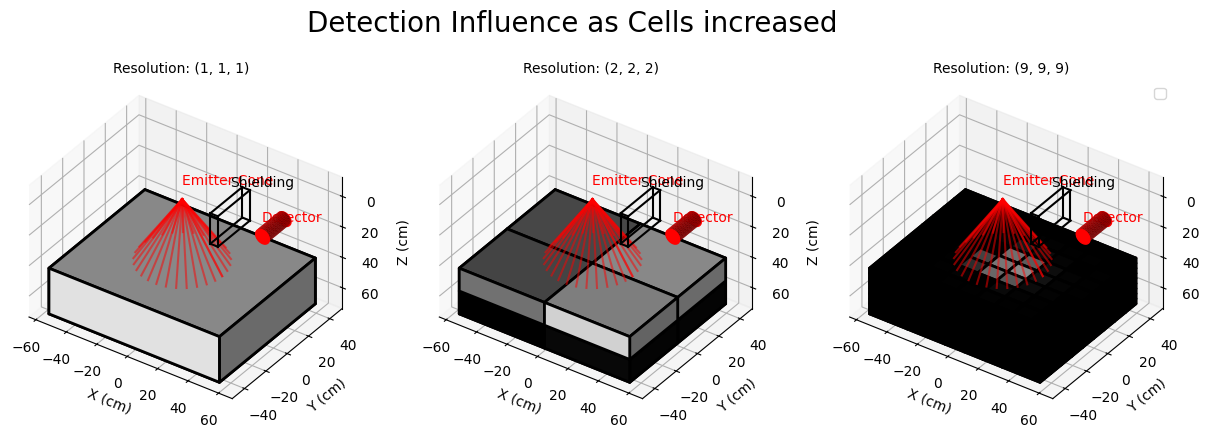

In [8]:
# c = 1

# midpoints = midpointss[c]
# soil_resolution = soil_resolutions[c]


# depth = midpoints[:, 2]
# x = midpoints[:, 0]
# y = midpoints[:, 1]
# depth_prob = cell_heatings_df.iloc[c].cell_heatings.sum(axis=1)

# # histogram with depth as bins
# hist = plt.hist(-depth, bins=np.sort(-np.array(sidess[0][2])), weights=depth_prob, alpha=0.5)
# # plt.plot(hist[1][:-1], hist[0], label='Depth Probability Distribution', color='blue')
# plt.xlabel('Depth (cm)')
# plt.ylabel('Probability')
# plt.title('Depth Signal Distribution')
# plt.grid()
# plt.show()



def cloud_from_cloud(
        ax0, cloud, filter_mask, midpoints,
        alpha=1, 
        color='green',
        zorder=1002,
        c=1,
        ):
    
    # print(f'cloud_from_cloud: {cloud.shape}\n filter {midpoints.shape}\n cell_portions {cell_portions[c].shape}')
    cell_mask_vox = pltt.vox_maker(
        cloud, 
        midpoints, 
        cell_portions[c]
        )
    
    cell_mask_vox = cell_mask_vox & filter_mask
    
    pltt.concave_hull(
        ax0, 
        cell_mask_vox, 
        sidess[c], 
        color=color, 
        alpha=alpha,
        zorder=zorder
        )
    

def cloud3(ax, filter_mask, midpoints, c=1, colors=None):
    # pass
    # The filled argument must be 3D, so we need to reshape total_soil_heating to match the shape of sidess[c]
    # Let's assume sidess[c] is a tuple of 3 arrays representing the grid, and their shapes match the 3D grid shape
    # We'll try to reshape total_soil_heating to the shape of sidess[c][0]
    _shape = [len(sidess[c][0])-1, len(sidess[c][1])-1, len(sidess[c][2])-1]
    x_sides = sidess[c][0]
    y_sides = sidess[c][1]
    z_sides = sidess[c][2]
    z_sides = np.array(z_sides)
    z_sides = -z_sides+42
    filled = np.ones(_shape, dtype=bool)
    # print(f'filled: {filled.shape}')
    # print(f'sides: {z_sides}')
    x, y, z = np.meshgrid(
        x_sides, y_sides, z_sides,# indexing='ij'
    )

    carbon_level = carbon_levels[c]
    carbon_level = (carbon_level-_min)
    carbon_level = carbon_level/(_max-_min)
    carbon_level = plt.colormaps['viridis'](carbon_level)
    carbon_level = carbon_level.reshape(_shape+[4])
    
    cell_portion = np.array(cell_portions_df.iloc[c].cell_portions)
    min_portions = np.min(cell_portion)
    max_portions = np.max(cell_portion)
    if min_portions == max_portions:
        min_portions = 0
        max_portions = 1
    else:
        cell_portion = cell_portion- min_portions
        cell_portion = cell_portion/(max_portions-min_portions)
    cell_portion = cell_portion.reshape(_shape)
    if np.array_equal(cell_portion, np.zeros_like(cell_portion)):
        cell_portion = np.ones_like(cell_portion)
    cell_portion = plt.colormaps['gray'](cell_portion)
    cell_portion = cell_portion.reshape(_shape+[4])
    

    ax.voxels(
        x, y, z, filled,
        facecolors=cell_portion,
        edgecolor='k', linewidth=2,
    )
    # cloud_from_cloud(
    #     ax, 
    #     clouds['99'][c], 
    #     filter_mask, 
    #     midpoints,
    #     alpha=1, 
    #     color='red',
    #     zorder=1002,
    #     c=c,
    #     )


    # cloud_from_cloud(
    #     ax, 
    #     clouds['95'][c], 
    #     filter_mask, 
    #     midpoints,
    #     alpha=1, 
    #     color='orange',
    #     zorder=1002,
    #     c=c,
    #     )


    # cloud_from_cloud(
    #     ax, 
    #     clouds['90'][c], 
    #     filter_mask, 
    #     midpoints,
    #     alpha=1, 
    #     color='yellow',
    #     zorder=1002,
    #     c=c,
    #     )

soil_on_ax = lambda ax: pltt.plot_box(ax, -56, 56, -45, 45, 42, 42+30, color='brown', alpha=.5, label='Soil', zorder=1)


fig, axs = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(5*3, 5*1))

# side

def tripleview(axs, c=1):
    # c = 1

    midpoints = midpointss[c]
    soil_resolution = soil_resolutions[c]
    soil_res = [int(s) for s in soil_resolution.split('x')]
    # print(midpoints.shape, soil_res)

    depth = midpoints[:, 2]
    x = midpoints[:, 0]
    y = midpoints[:, 1]
    depth_prob = cell_heatings_df.iloc[c].cell_heatings.sum(axis=1)

    ax0 = axs
    ax0.set_title(f'Resolution: {tuple(soil_res)}', fontsize=10)
    soil_on_ax(ax0)
    # ax0.set_ylim([0, 50])
    filter_mask = (midpoints[:, 1]>-0.1).reshape(soil_res)
    # print(filter_mask.shape, soil_res)
    cloud3(ax0, filter_mask, midpoints, c=c,)
    pltt.plot_cone(ax0, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='red', alpha=.5, label='Emitter Cone', zorder=2000)
    pltt.plot_cylinder(ax0, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='red', alpha=1, label='Detector', zorder=200101)
    pltt.plot_box(ax0, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    pltt.extra(ax0)
    ax0.view_init(elev=35, azim=-90+35,)
    # ax0.set_yticklabels([])
    # ax0.set_yticks([]) 
    # ax0.set_ylabel('')
    ax0.set_aspect('equal')
    plt.legend()

    # # top
    # ax1 = axs[1]
    # ax1.set_title('Top View', fontsize=30)
    # soil_on_ax(ax1)
    # ax1.set_zlim([42.1, 100])
    # filter_mask = np.ones(soil_res, dtype=bool)
    # cloud3(ax1, filter_mask, midpoints, c=c,)
    # pltt.plot_cone(ax1, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
    # pltt.plot_cylinder(ax1, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
    # pltt.plot_box(ax1, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    # pltt.extra(ax1)
    # ax1.view_init(elev=35, azim=-90+35,)
    # ax1.set_zticklabels([])
    # ax1.set_zticks([])
    # ax1.set_zlabel('')
    # ax1.set_aspect('equal')

    # # front
    # ax2 = axs[2]
    # ax2.set_title('Front View', fontsize=30)
    # soil_on_ax(ax2)
    # ax2.set_xlim([-60, 15])
    # filter_mask = (midpoints[:, 0]<20).reshape(soil_res)
    # cloud3(ax2, filter_mask, midpoints, c=c,)
    # pltt.plot_cone(ax2, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
    # pltt.plot_cylinder(ax2, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
    # pltt.plot_box(ax2, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    # pltt.extra(ax2)
    # ax2.view_init(elev=0, azim=0,)
    # ax2.set_xticklabels([])
    # ax2.set_xticks([])
    # ax2.set_xlabel('')
    # ax2.set_aspect('equal')
c=2
# fig.suptitle(f'Cell Portion of Total Heating for {filenames[c]}', fontsize=10)

tripleview(axs[0], c=0)
tripleview(axs[1], c=2)
tripleview(axs[2], c=3)
plt.suptitle(f'Detection Influence as Cells increased', fontsize=20)
plt.savefig('../../Figures/MCNP/CellRatioMesh.png', dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_921380/737208567.py:162: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


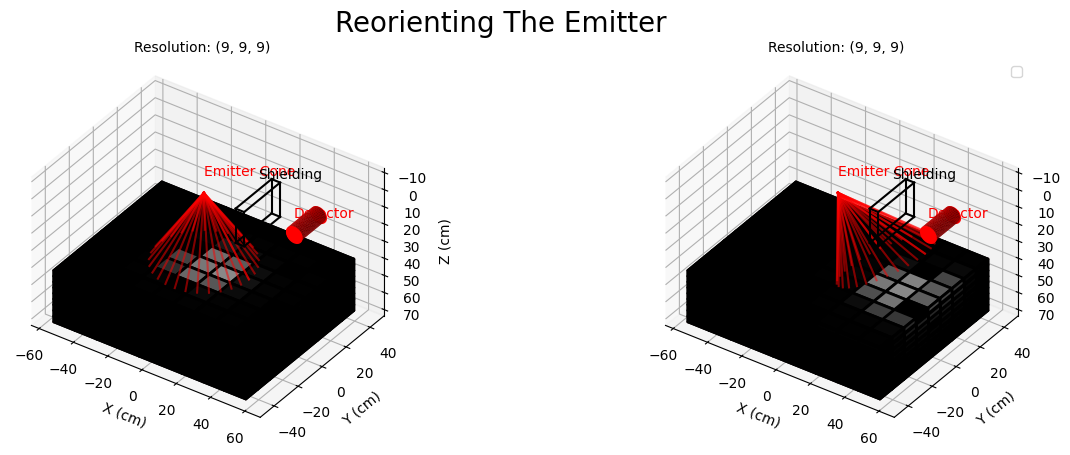

In [9]:
# c = 1

# midpoints = midpointss[c]
# soil_resolution = soil_resolutions[c]


# depth = midpoints[:, 2]
# x = midpoints[:, 0]
# y = midpoints[:, 1]
# depth_prob = cell_heatings_df.iloc[c].cell_heatings.sum(axis=1)

# # histogram with depth as bins
# hist = plt.hist(-depth, bins=np.sort(-np.array(sidess[0][2])), weights=depth_prob, alpha=0.5)
# # plt.plot(hist[1][:-1], hist[0], label='Depth Probability Distribution', color='blue')
# plt.xlabel('Depth (cm)')
# plt.ylabel('Probability')
# plt.title('Depth Signal Distribution')
# plt.grid()
# plt.show()



def cloud_from_cloud(
        ax0, cloud, filter_mask, midpoints,
        alpha=1, 
        color='green',
        zorder=1002,
        c=1,
        ):
    
    # print(f'cloud_from_cloud: {cloud.shape}\n filter {midpoints.shape}\n cell_portions {cell_portions[c].shape}')
    cell_mask_vox = pltt.vox_maker(
        cloud, 
        midpoints, 
        cell_portions[c]
        )
    
    cell_mask_vox = cell_mask_vox & filter_mask
    
    pltt.concave_hull(
        ax0, 
        cell_mask_vox, 
        sidess[c], 
        color=color, 
        alpha=alpha,
        zorder=zorder
        )
    

def cloud3(ax, filter_mask, midpoints, c=1, colors=None):
    # pass
    # The filled argument must be 3D, so we need to reshape total_soil_heating to match the shape of sidess[c]
    # Let's assume sidess[c] is a tuple of 3 arrays representing the grid, and their shapes match the 3D grid shape
    # We'll try to reshape total_soil_heating to the shape of sidess[c][0]
    _shape = [len(sidess[c][0])-1, len(sidess[c][1])-1, len(sidess[c][2])-1]
    x_sides = sidess[c][0]
    y_sides = sidess[c][1]
    z_sides = sidess[c][2]
    z_sides = np.array(z_sides)
    z_sides = -z_sides+42
    filled = np.ones(_shape, dtype=bool)
    # print(f'filled: {filled.shape}')
    # print(f'sides: {z_sides}')
    x, y, z = np.meshgrid(
        x_sides, y_sides, z_sides,# indexing='ij'
    )

    carbon_level = carbon_levels[c]
    carbon_level = (carbon_level-_min)
    carbon_level = carbon_level/(_max-_min)
    carbon_level = plt.colormaps['viridis'](carbon_level)
    carbon_level = carbon_level.reshape(_shape+[4])
    
    cell_portion = np.array(cell_portions_df.iloc[c].cell_portions)
    min_portions = np.min(cell_portion)
    max_portions = np.max(cell_portion)
    cell_portion = cell_portion- min_portions
    cell_portion = cell_portion/(max_portions-min_portions)
    cell_portion = cell_portion.reshape(_shape)
    if np.array_equal(cell_portion, np.zeros_like(cell_portion)):
        cell_portion = np.ones_like(cell_portion)
    cell_portion = plt.colormaps['gray'](cell_portion)
    cell_portion = cell_portion.reshape(_shape+[4])
    

    ax.voxels(
        x, y, z, filled,
        facecolors=cell_portion,
        edgecolor='k', linewidth=2,
    )
    # cloud_from_cloud(
    #     ax, 
    #     clouds['99'][c], 
    #     filter_mask, 
    #     midpoints,
    #     alpha=1, 
    #     color='red',
    #     zorder=1002,
    #     c=c,
    #     )


    # cloud_from_cloud(
    #     ax, 
    #     clouds['95'][c], 
    #     filter_mask, 
    #     midpoints,
    #     alpha=1, 
    #     color='orange',
    #     zorder=1002,
    #     c=c,
    #     )


    # cloud_from_cloud(
    #     ax, 
    #     clouds['90'][c], 
    #     filter_mask, 
    #     midpoints,
    #     alpha=1, 
    #     color='yellow',
    #     zorder=1002,
    #     c=c,
    #     )

soil_on_ax = lambda ax: pltt.plot_box(ax, -56, 56, -45, 45, 42, 42+30, color='brown', alpha=.5, label='Soil', zorder=1)


fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(5*3, 5*1))

# side

def tripleview(axs, c=1, vec=(0, 0, 1.0)):
    # c = 1

    midpoints = midpointss[c]
    soil_resolution = soil_resolutions[c]
    soil_res = [int(s) for s in soil_resolution.split('x')]
    # print(midpoints.shape, soil_res)

    depth = midpoints[:, 2]
    x = midpoints[:, 0]
    y = midpoints[:, 1]
    depth_prob = cell_heatings_df.iloc[c].cell_heatings.sum(axis=1)

    ax0 = axs
    ax0.set_title(f'Resolution: {tuple(soil_res)}', fontsize=10)
    soil_on_ax(ax0)
    # ax0.set_ylim([0, 50])
    filter_mask = (midpoints[:, 1]>-0.1).reshape(soil_res)
    # print(filter_mask.shape, soil_res)
    cloud3(ax0, filter_mask, midpoints, c=c,)
    pltt.plot_cone(ax0, pos=(0, 0, 0), vec=vec, dir=np.degrees(np.cos(.95)), length=40, color='red', alpha=.5, label='Emitter Cone', zorder=2000)
    pltt.plot_cylinder(ax0, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='red', alpha=1, label='Detector', zorder=200101)
    pltt.plot_box(ax0, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    pltt.extra(ax0)
    ax0.view_init(elev=35, azim=-90+35,)
    # ax0.set_yticklabels([])
    # ax0.set_yticks([]) 
    # ax0.set_ylabel('')
    ax0.set_aspect('equal')
    plt.legend()

    # # top
    # ax1 = axs[1]
    # ax1.set_title('Top View', fontsize=30)
    # soil_on_ax(ax1)
    # ax1.set_zlim([42.1, 100])
    # filter_mask = np.ones(soil_res, dtype=bool)
    # cloud3(ax1, filter_mask, midpoints, c=c,)
    # pltt.plot_cone(ax1, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
    # pltt.plot_cylinder(ax1, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
    # pltt.plot_box(ax1, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    # pltt.extra(ax1)
    # ax1.view_init(elev=35, azim=-90+35,)
    # ax1.set_zticklabels([])
    # ax1.set_zticks([])
    # ax1.set_zlabel('')
    # ax1.set_aspect('equal')

    # # front
    # ax2 = axs[2]
    # ax2.set_title('Front View', fontsize=30)
    # soil_on_ax(ax2)
    # ax2.set_xlim([-60, 15])
    # filter_mask = (midpoints[:, 0]<20).reshape(soil_res)
    # cloud3(ax2, filter_mask, midpoints, c=c,)
    # pltt.plot_cone(ax2, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
    # pltt.plot_cylinder(ax2, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
    # pltt.plot_box(ax2, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    # pltt.extra(ax2)
    # ax2.view_init(elev=0, azim=0,)
    # ax2.set_xticklabels([])
    # ax2.set_xticks([])
    # ax2.set_xlabel('')
    # ax2.set_aspect('equal')
c=2
# fig.suptitle(f'Cell Portion of Total Heating for {filenames[c]}', fontsize=10)

tripleview(axs[0], c=3, vec=(0.0, 0, 1.0))
tripleview(axs[1], c=5, vec=(0.5, 0.0, .5))
plt.suptitle(f'Reorienting The Emitter', fontsize=20)
plt.savefig('../../Figures/MCNP/DetectorDirectiontoMeasuredDensity.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
(6946/60)/60

1.9294444444444445

/tmp/ipykernel_921380/3630826188.py:167: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


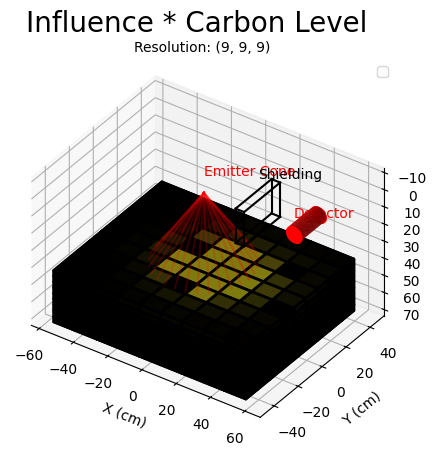

In [11]:
# c = 1

# midpoints = midpointss[c]
# soil_resolution = soil_resolutions[c]


# depth = midpoints[:, 2]
# x = midpoints[:, 0]
# y = midpoints[:, 1]
# depth_prob = cell_heatings_df.iloc[c].cell_heatings.sum(axis=1)

# # histogram with depth as bins
# hist = plt.hist(-depth, bins=np.sort(-np.array(sidess[0][2])), weights=depth_prob, alpha=0.5)
# # plt.plot(hist[1][:-1], hist[0], label='Depth Probability Distribution', color='blue')
# plt.xlabel('Depth (cm)')
# plt.ylabel('Probability')
# plt.title('Depth Signal Distribution')
# plt.grid()
# plt.show()



def cloud_from_cloud(
        ax0, cloud, filter_mask, midpoints,
        alpha=1, 
        color='green',
        zorder=1002,
        c=1,
        ):
    
    # print(f'cloud_from_cloud: {cloud.shape}\n filter {midpoints.shape}\n cell_portions {cell_portions[c].shape}')
    cell_mask_vox = pltt.vox_maker(
        cloud, 
        midpoints, 
        cell_portions[c]
        )
    
    cell_mask_vox = cell_mask_vox & filter_mask
    
    pltt.concave_hull(
        ax0, 
        cell_mask_vox, 
        sidess[c], 
        color=color, 
        alpha=alpha,
        zorder=zorder
        )
    

def cloud3(ax, filter_mask, midpoints, c=1, colors=None):
    # pass
    # The filled argument must be 3D, so we need to reshape total_soil_heating to match the shape of sidess[c]
    # Let's assume sidess[c] is a tuple of 3 arrays representing the grid, and their shapes match the 3D grid shape
    # We'll try to reshape total_soil_heating to the shape of sidess[c][0]
    _shape = [len(sidess[c][0])-1, len(sidess[c][1])-1, len(sidess[c][2])-1]
    x_sides = sidess[c][0]
    y_sides = sidess[c][1]
    z_sides = sidess[c][2]
    z_sides = np.array(z_sides)
    z_sides = -z_sides+42
    filled = np.ones(_shape, dtype=bool)
    # print(f'filled: {filled.shape}')
    # print(f'sides: {z_sides}')
    x, y, z = np.meshgrid(
        x_sides, y_sides, z_sides
    )

    carbon_level = carbon_levels[c]
    carbon_level = (carbon_level-_min)
    carbon_level = carbon_level/(_max-_min)
    carbon_level = plt.colormaps['viridis'](carbon_level)
    carbon_level = carbon_level.reshape(_shape+[4])
    
    cell_portion = np.array(cell_portions_df.iloc[c].cell_portions)
    min_portions = np.min(cell_portion)
    max_portions = np.max(cell_portion)
    if min_portions == max_portions:
        min_portions = 0
        max_portions = 1
    else:
        cell_portion = cell_portion- min_portions
        cell_portion = cell_portion/(max_portions-min_portions)
    cell_portion = cell_portion/(max_portions-min_portions)
    cell_portion = cell_portion.reshape(_shape)
    if np.array_equal(cell_portion, np.zeros_like(cell_portion)):
        cell_portion = np.ones_like(cell_portion)
    cell_portion = plt.colormaps['gray'](cell_portion)
    cell_portion = cell_portion.reshape(_shape+[4])
    

    ax.voxels(
        x, y, z, filled,
        facecolors=carbon_level*cell_portion,
        edgecolor='k', linewidth=2,
    )
    # cloud_from_cloud(
    #     ax, 
    #     clouds['99'][c], 
    #     filter_mask, 
    #     midpoints,
    #     alpha=1, 
    #     color='red',
    #     zorder=1002,
    #     c=c,
    #     )


    # cloud_from_cloud(
    #     ax, 
    #     clouds['95'][c], 
    #     filter_mask, 
    #     midpoints,
    #     alpha=1, 
    #     color='orange',
    #     zorder=1002,
    #     c=c,
    #     )


    # cloud_from_cloud(
    #     ax, 
    #     clouds['90'][c], 
    #     filter_mask, 
    #     midpoints,
    #     alpha=1, 
    #     color='yellow',
    #     zorder=1002,
    #     c=c,
    #     )

soil_on_ax = lambda ax: pltt.plot_box(ax, -56, 56, -45, 45, 42, 42+30, color='brown', alpha=.5, label='Soil', zorder=1)


fig, axs = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(5*1, 5*1))

# side

def tripleview(axs, c=1):
    # c = 1

    midpoints = midpointss[c]
    soil_resolution = soil_resolutions[c]
    soil_res = [int(s) for s in soil_resolution.split('x')]
    # print(midpoints.shape, soil_res)

    depth = midpoints[:, 2]
    x = midpoints[:, 0]
    y = midpoints[:, 1]
    depth_prob = cell_heatings_df.iloc[c].cell_heatings.sum(axis=1)

    ax0 = axs
    ax0.set_title(f'Resolution: {tuple(soil_res)}', fontsize=10)
    soil_on_ax(ax0)
    # ax0.set_ylim([0, 50])
    filter_mask = (midpoints[:, 1]>-0.1).reshape(soil_res)
    # print(filter_mask.shape, soil_res)
    cloud3(ax0, filter_mask, midpoints, c=c,)
    pltt.plot_cone(ax0, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='red', alpha=.2, label='Emitter Cone', zorder=2000)
    pltt.plot_cylinder(ax0, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='red', alpha=1, label='Detector', zorder=200101)
    pltt.plot_box(ax0, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    pltt.extra(ax0)
    ax0.view_init(elev=35, azim=-90+35,)
    # ax0.set_yticklabels([])
    # ax0.set_yticks([]) 
    # ax0.set_ylabel('')
    ax0.set_aspect('equal')
    plt.legend()

    # # top
    # ax1 = axs[1]
    # ax1.set_title('Top View', fontsize=30)
    # soil_on_ax(ax1)
    # ax1.set_zlim([42.1, 100])
    # filter_mask = np.ones(soil_res, dtype=bool)
    # cloud3(ax1, filter_mask, midpoints, c=c,)
    # pltt.plot_cone(ax1, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
    # pltt.plot_cylinder(ax1, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
    # pltt.plot_box(ax1, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    # pltt.extra(ax1)
    # ax1.view_init(elev=35, azim=-90+35,)
    # ax1.set_zticklabels([])
    # ax1.set_zticks([])
    # ax1.set_zlabel('')
    # ax1.set_aspect('equal')

    # # front
    # ax2 = axs[2]
    # ax2.set_title('Front View', fontsize=30)
    # soil_on_ax(ax2)
    # ax2.set_xlim([-60, 15])
    # filter_mask = (midpoints[:, 0]<20).reshape(soil_res)
    # cloud3(ax2, filter_mask, midpoints, c=c,)
    # pltt.plot_cone(ax2, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
    # pltt.plot_cylinder(ax2, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
    # pltt.plot_box(ax2, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    # pltt.extra(ax2)
    # ax2.view_init(elev=0, azim=0,)
    # ax2.set_xticklabels([])
    # ax2.set_xticks([])
    # ax2.set_xlabel('')
    # ax2.set_aspect('equal')
c=2
# fig.suptitle(f'Cell Portion of Total Heating for {filenames[c]}', fontsize=10)

# tripleview(axs[0], c=0)
# tripleview(axs[1], c=2)
tripleview(axs, c=3)
plt.suptitle(f'Influence * Carbon Level', fontsize=20)
plt.savefig('../../Figures/MCNP/InfluenceTimesCarbonLevel.png', dpi=300, bbox_inches='tight')
plt.show()
plt.show()


In [12]:
cell_portion.shape

(729,)

In [13]:
cell_portions_df

,filename,cell_portions
0,1x1x1_Gradient_005000,[1.0]
1,1x1x1_Vs9_005001,[1.0]
2,2x2x2_Gradient_005003,"[0.01080685467616358, 0.16132936776068918, 0.0..."
3,9x9x9_Gradient_005006,"[3.590150154611593e-08, 7.612801081338896e-08,..."
4,9x9x9_Vs9_005007,"[0.0, 7.666737004880888e-08, 1.359915380986516..."
5,9x9x9_Tilt_005008,"[0.0, 0.0, 4.773839618772699e-09, 0.0, 8.82511..."


/tmp/ipykernel_921380/3145875019.py:153: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


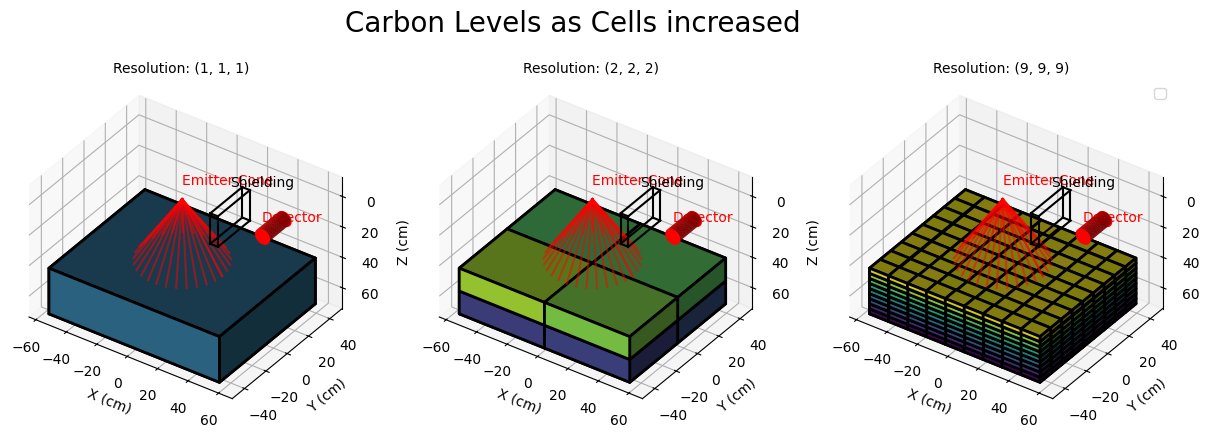

In [14]:
# c = 1

# midpoints = midpointss[c]
# soil_resolution = soil_resolutions[c]


# depth = midpoints[:, 2]
# x = midpoints[:, 0]
# y = midpoints[:, 1]
# depth_prob = cell_heatings_df.iloc[c].cell_heatings.sum(axis=1)

# # histogram with depth as bins
# hist = plt.hist(-depth, bins=np.sort(-np.array(sidess[0][2])), weights=depth_prob, alpha=0.5)
# # plt.plot(hist[1][:-1], hist[0], label='Depth Probability Distribution', color='blue')
# plt.xlabel('Depth (cm)')
# plt.ylabel('Probability')
# plt.title('Depth Signal Distribution')
# plt.grid()
# plt.show()



def cloud_from_cloud(
        ax0, cloud, filter_mask, midpoints,
        alpha=1, 
        color='green',
        zorder=1002,
        c=1,
        ):
    
    # print(f'cloud_from_cloud: {cloud.shape}\n filter {midpoints.shape}\n cell_portions {cell_portions[c].shape}')
    cell_mask_vox = pltt.vox_maker(
        cloud, 
        midpoints, 
        cell_portions[c]
        )
    
    cell_mask_vox = cell_mask_vox & filter_mask
    
    pltt.concave_hull(
        ax0, 
        cell_mask_vox, 
        sidess[c], 
        color=color, 
        alpha=alpha,
        zorder=zorder
        )
    

def cloud3(ax, filter_mask, midpoints, c=1, colors=None):
    # pass
    # The filled argument must be 3D, so we need to reshape total_soil_heating to match the shape of sidess[c]
    # Let's assume sidess[c] is a tuple of 3 arrays representing the grid, and their shapes match the 3D grid shape
    # We'll try to reshape total_soil_heating to the shape of sidess[c][0]
    _shape = [len(sidess[c][0])-1, len(sidess[c][1])-1, len(sidess[c][2])-1]
    x_sides = sidess[c][0]
    y_sides = sidess[c][1]
    z_sides = sidess[c][2]
    z_sides = np.array(z_sides)
    z_sides = -z_sides+42
    filled = np.ones(_shape, dtype=bool)
    # print(f'filled: {filled.shape}')
    # print(f'sides: {z_sides}')
    x, y, z = np.meshgrid(
        x_sides, y_sides, z_sides
    )

    carbon_level = carbon_levels[c]
    carbon_level = (carbon_level-_min)
    carbon_level = carbon_level/(_max-_min)
    # print(carbon_level)
    carbon_level = plt.colormaps['viridis'](carbon_level)
    vox_colors = np.zeros(_shape+[4])
    
    carbon_level = carbon_level.reshape(_shape+[4])
    
    ax.voxels(
        x, y, z, filled,
        facecolors=carbon_level,
        edgecolor='k', linewidth=2,
    )
    # cloud_from_cloud(
    #     ax, 
    #     clouds['99'][c], 
    #     filter_mask, 
    #     midpoints,
    #     alpha=1, 
    #     color='red',
    #     zorder=1002,
    #     c=c,
    #     )


    # cloud_from_cloud(
    #     ax, 
    #     clouds['95'][c], 
    #     filter_mask, 
    #     midpoints,
    #     alpha=1, 
    #     color='orange',
    #     zorder=1002,
    #     c=c,
    #     )


    # cloud_from_cloud(
    #     ax, 
    #     clouds['90'][c], 
    #     filter_mask, 
    #     midpoints,
    #     alpha=1, 
    #     color='yellow',
    #     zorder=1002,
    #     c=c,
    #     )

soil_on_ax = lambda ax: pltt.plot_box(ax, -56, 56, -45, 45, 42, 42+30, color='brown', alpha=.5, label='Soil', zorder=1)


fig, axs = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(5*3, 5*1))

# side

def tripleview(axs, c=1):
    # c = 1

    midpoints = midpointss[c]
    soil_resolution = soil_resolutions[c]
    soil_res = [int(s) for s in soil_resolution.split('x')]
    # print(midpoints.shape, soil_res)

    depth = midpoints[:, 2]
    x = midpoints[:, 0]
    y = midpoints[:, 1]
    depth_prob = cell_heatings_df.iloc[c].cell_heatings.sum(axis=1)

    ax0 = axs
    ax0.set_title(f'Resolution: {tuple(soil_res)}', fontsize=10)
    soil_on_ax(ax0)
    # ax0.set_ylim([0, 50])
    filter_mask = (midpoints[:, 1]>-0.1).reshape(soil_res)
    # print(filter_mask.shape, soil_res)
    cloud3(ax0, filter_mask, midpoints, c=c,)
    pltt.plot_cone(ax0, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='red', alpha=.5, label='Emitter Cone', zorder=2000)
    pltt.plot_cylinder(ax0, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='red', alpha=1, label='Detector', zorder=200101)
    pltt.plot_box(ax0, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    pltt.extra(ax0)
    ax0.view_init(elev=35, azim=-90+35,)
    # ax0.set_yticklabels([])
    # ax0.set_yticks([]) 
    # ax0.set_ylabel('')
    ax0.set_aspect('equal')
    plt.legend()

    # # top
    # ax1 = axs[1]
    # ax1.set_title('Top View', fontsize=30)
    # soil_on_ax(ax1)
    # ax1.set_zlim([42.1, 100])
    # filter_mask = np.ones(soil_res, dtype=bool)
    # cloud3(ax1, filter_mask, midpoints, c=c,)
    # pltt.plot_cone(ax1, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
    # pltt.plot_cylinder(ax1, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
    # pltt.plot_box(ax1, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    # pltt.extra(ax1)
    # ax1.view_init(elev=35, azim=-90+35,)
    # ax1.set_zticklabels([])
    # ax1.set_zticks([])
    # ax1.set_zlabel('')
    # ax1.set_aspect('equal')

    # # front
    # ax2 = axs[2]
    # ax2.set_title('Front View', fontsize=30)
    # soil_on_ax(ax2)
    # ax2.set_xlim([-60, 15])
    # filter_mask = (midpoints[:, 0]<20).reshape(soil_res)
    # cloud3(ax2, filter_mask, midpoints, c=c,)
    # pltt.plot_cone(ax2, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='blue', alpha=.5, label='Emitter Cone', zorder=2000)
    # pltt.plot_cylinder(ax2, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='blue', alpha=1, label='Detector', zorder=200101)
    # pltt.plot_box(ax2, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    # pltt.extra(ax2)
    # ax2.view_init(elev=0, azim=0,)
    # ax2.set_xticklabels([])
    # ax2.set_xticks([])
    # ax2.set_xlabel('')
    # ax2.set_aspect('equal')
c=2
# fig.suptitle(f'Cell Portion of Total Heating for {filenames[c]}', fontsize=10)

tripleview(axs[0], c=0)
tripleview(axs[1], c=2)
tripleview(axs[2], c=3)
plt.suptitle(f'Carbon Levels as Cells increased', fontsize=20)
plt.savefig('../../Figures/MCNP/SingleToManyCells.png', dpi=300, bbox_inches='tight')
# plt.tight_layout()

In [15]:
cell_portions[1]

array([1.])

In [16]:
sum(carbon_levels[2]*cell_portions[2])

np.float64(0.07345461343512238)

In [17]:
cell_portions[1]

array([1.])

In [18]:
carbon_levels[1]

array([0.08148731])

In [19]:
sum(carbon_levels[2]*cell_portions[2])

np.float64(0.07345461343512238)

In [20]:
sum(carbon_levels[1]*cell_portions[1])

np.float64(0.0814873060152928)

In [21]:
sum(carbon_levels[0])

np.float64(0.037022550848553)

In [22]:
elem_maps[0]

,Unnamed: 0,90
0,14028,0.306089
1,13027,0.163092
2,1001,0.000000
3,11023,0.000000
4,8016,0.493796
5,26000,0.000000
6,12024,0.000000
7,6000,0.037023


In [23]:
sims_df

,soil_resolution,function,id,filename
0,1x1x1,Gradient,5000,1x1x1_Gradient_005000
1,1x1x1,Vs9,5001,1x1x1_Vs9_005001
2,2x2x2,Gradient,5003,2x2x2_Gradient_005003
3,9x9x9,Gradient,5006,9x9x9_Gradient_005006
4,9x9x9,Vs9,5007,9x9x9_Vs9_005007
5,9x9x9,Tilt,5008,9x9x9_Tilt_005008


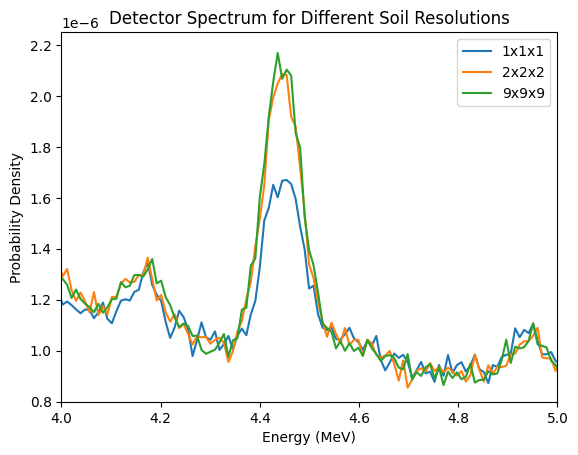

In [24]:
plt.figure()
for i in [0, 2, 3]:
    plt.plot(detector_energy_bins, [detector_spectrum.flatten() for detector_spectrum in detector_spectrums][i], label=f'{sims_df["soil_resolution"][i]}', alpha=1)
# plt.yscale('log')
plt.legend()
plt.xlim([4, 5])
plt.ylim([8e-7, 2.25e-6])
plt.xlabel('Energy (MeV)')
plt.ylabel('Probability Density')
plt.title('Detector Spectrum for Different Soil Resolutions')
plt.savefig('../../Figures/MCNP/Effectsofresolutionondetection.png', dpi=300, bbox_inches='tight')

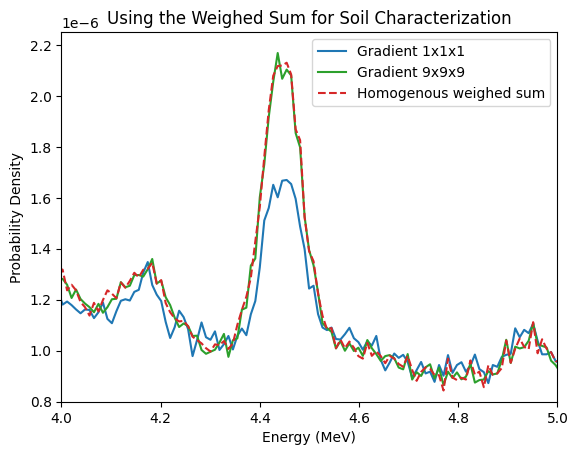

In [25]:
plt.figure()
for i in [0, 3, 4]:
    pass
i=0
plt.plot(detector_energy_bins, [detector_spectrum.flatten() for detector_spectrum in detector_spectrums][i], label=f'{sims_df["function"][i]} {sims_df["soil_resolution"][i]}', alpha=1, color='tab:blue')
i=3
plt.plot(detector_energy_bins, [detector_spectrum.flatten() for detector_spectrum in detector_spectrums][i], label=f'{sims_df["function"][i]} {sims_df["soil_resolution"][i]}', alpha=1, color='tab:green')
i=4
plt.plot(detector_energy_bins, [detector_spectrum.flatten() for detector_spectrum in detector_spectrums][i], label=f'Homogenous weighed sum', alpha=1, color='tab:red', linestyle='--')

# plt.yscale('log')
plt.legend()
plt.xlim([4, 5])
plt.ylim([8e-7, 2.25e-6])
plt.xlabel('Energy (MeV)')
plt.ylabel('Probability Density')
plt.title('Using the Weighed Sum for Soil Characterization')
plt.savefig('../../Figures/MCNP/GradientWeighedAvgvsHomogeneousAvg.png', dpi=300, bbox_inches='tight')